<h1>Import required libraries</h1>

In [ ]:
import os
from fastai.vision import *
from fastai.metrics import error_rate
from sklearn.metrics import f1_score, classification_report
from fastai.basic_data import DatasetType
import numpy as np
import torch

Check whether GPU is available to perform processing.<br>
If the below line outputs <b>False</b>, all processing will happen on the CPU, which is significantly slower

In [2]:
torch.cuda.is_available()

True

Set <b>image size</b> and <b>batch size</b>

In [3]:
sz = 64
bs = 64

<h2>Load the images using ImageDataBunch</h2>

In [4]:
data = ImageDataBunch.from_csv('.', folder='data/', size=sz, bs=bs, 
                               ds_tfms=get_transforms(do_flip=False, max_zoom=1.)).normalize(imagenet_stats)

In [5]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (13140 items)
[Category 338, Category 0, Category 0, Category 0, Category 0]...
Path: .
x: ImageItemList (13140 items)
[Image (3, 900, 1200), Image (3, 900, 1200), Image (3, 900, 1200), Image (3, 900, 1200), Image (3, 900, 1200)]...
Path: .;

Valid: LabelList
y: CategoryList (3285 items)
[Category 534, Category 430, Category 444, Category 423, Category 554]...
Path: .
x: ImageItemList (3285 items)
[Image (3, 900, 1200), Image (3, 900, 1200), Image (3, 900, 1200), Image (3, 900, 1200), Image (3, 900, 1200)]...
Path: .;

Test: None

<h3>Check whether the images have loaded properly</h3> 

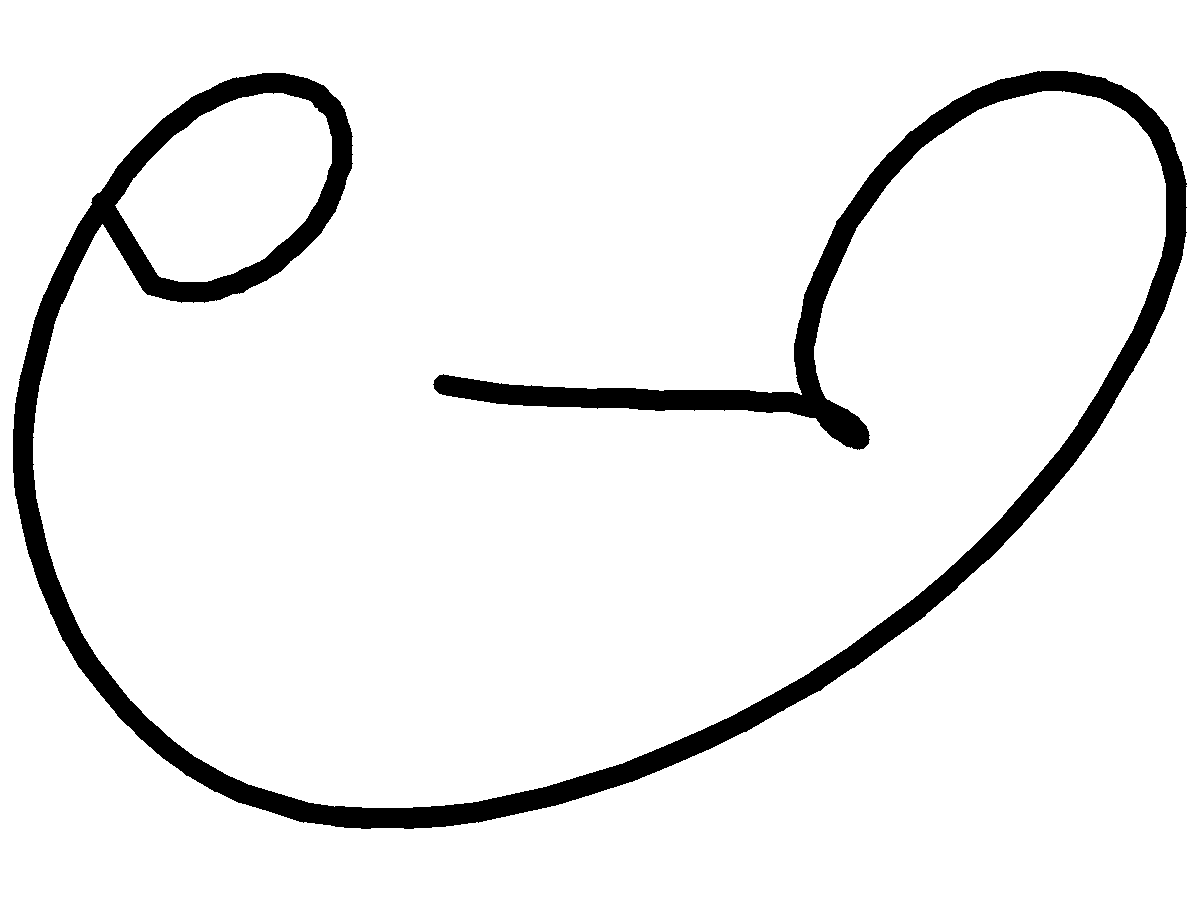

In [7]:
data.train_ds.x[0]

We can also display a batch of images with the applied transforms

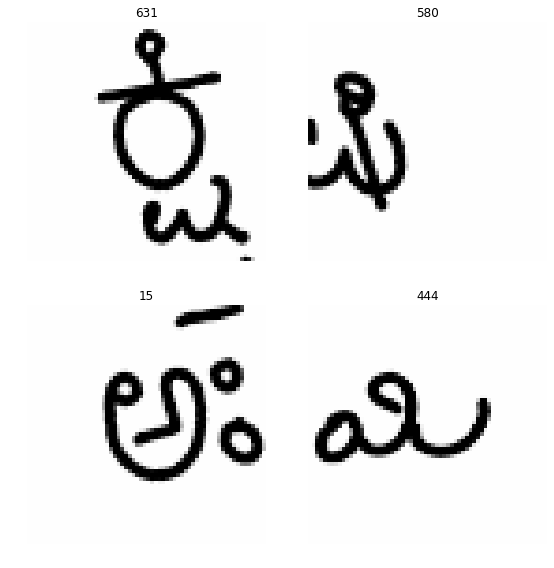

In [9]:
data.show_batch(rows=2)

<h1>Create a model to begin training.</h1>
<ul>
    <li>I have used a relatively simple pretrained ResNet18 network.</li>
    <li>And set the error metric as '<b>error_rate</b>' which is basically 1 - '<b>accuracy</b>'.</li>
    

In [6]:
learn = create_cnn(data, models.resnet18, metrics=[error_rate]).load('4_resnet18_0.86')

We can look at the model architecture

In [44]:
learn.model.summary()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

Using <b>lr_find</b> function to find the optimum learning rate.

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


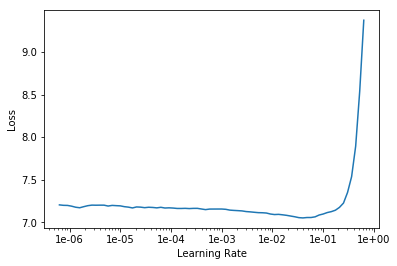

In [18]:
learn.recorder.plot()

Train the model with the optimum learning rate

In [19]:
learn.fit(2, 0.01)

epoch,train_loss,valid_loss,error_rate
1,4.930855,3.985311,0.846271
2,3.347235,2.914221,0.735464


Train the model with the optimum learning rate and with <b>cosine annhealing</b>.

In [20]:
learn.fit_one_cycle(4, 0.01)

epoch,train_loss,valid_loss,error_rate
1,2.504883,2.843563,0.713546
2,2.397729,2.096642,0.571385
3,1.795351,1.213723,0.363775
4,1.413342,1.052895,0.317504


Save the model just in case the <b>error_rate</b> get worse with further training.

In [21]:
learn.save('1_resnet18_0.65')

Unfreeze the top layers in order to train them

In [22]:
learn.unfreeze()

In [23]:
lr = 0.001
learn.fit_one_cycle(2, [lr/9, lr/3, lr])

epoch,train_loss,valid_loss,error_rate
1,1.423073,0.967676,0.276408
2,0.982740,0.642702,0.184779


In [24]:
learn.save('2_resnet18_0.80')

In [25]:
learn.fit_one_cycle(2, [lr/9, lr/3, lr])

epoch,train_loss,valid_loss,error_rate
1,1.126152,0.763488,0.232572
2,0.761815,0.495910,0.139117


Save the model.

In [26]:
learn.save('3_resnet18_0.85')

In [27]:
lr = 0.0001
learn.fit_one_cycle(2, [lr/9, lr/3, lr])

epoch,train_loss,valid_loss,error_rate
1,0.667587,0.474281,0.134855
2,0.638861,0.461255,0.129072


Use <b>cosine annhealing</b> and train.

In [28]:
learn.fit_one_cycle(5, [lr/9, lr/3, lr])

epoch,train_loss,valid_loss,error_rate
1,0.613025,0.460637,0.129072
2,0.623763,0.448039,0.125419
3,0.580721,0.431217,0.122374
4,0.565162,0.413852,0.117199
5,0.524925,0.418823,0.119939


Save the model

In [29]:
learn.save('4_resnet18_0.86')

<h1>Additional Steps</h1>
<br>
We can also calculate the F1 Score on the validation set.

In [50]:
preds, y = learn.get_preds(ds_type=DatasetType.Valid)

In [56]:
y_preds = preds.numpy()

In [60]:
y_pred = y_preds.argmax(axis=1)

In [65]:
f1_score(y, y_pred, average='micro')

0.8800608828006088

In [70]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      0.80      0.80         5
           2       1.00      1.00      1.00         4
           3       1.00      0.88      0.93         8
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         6
           8       0.83      1.00      0.91         5
           9       1.00      0.57      0.73         7
          10       1.00      0.67      0.80         3
          11       0.83      1.00      0.91         5
          12       1.00      0.75      0.86         4
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         6
          16       1.00      0.83      0.91         6
          17       0.80    